# Linear Regression by Numpy

## Introduction

This snippet arose because I was working my way through the ```statsmodels``` documentation.  This was as part of a process of converting a web lecture series I am reading from ```R``` to the Python ecosystem.

Anyway, I was working through using Ordinary Least Squares error minimization to perform linear regression, and realized I didn't fully understand what was going on behind the scenes.  So then I thought:  I will do it all again using Numpy, and  Python matrix multiplication.  The main reference I used was as below:

https://en.wikipedia.org/wiki/Explained_sum_of_squares

Caveats:  my Python formatter lays out matrix expressions in curious ways, so with bear with me here.  Also, the embedded mathematical expressions may not render correctly in all browsers.

---
## Notebook Initialization

```watermark``` helps document the environment; ```lab_black``` is my preferred Python formatter; and we need to tell ```matplotlib``` to draw plots inline.

In [27]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [28]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [29]:
%matplotlib inline

All imports go here.  I should probably update all my imports to the latest versions to fix the warning diagnostic.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from statsmodels.sandbox.regression.predstd import (
    wls_prediction_std,
)

----
## Data Creation

We create some linear data with added Gaussian noise.

In [31]:
n_data = 200
x1 = np.linspace(0, 100, n_data)
x0 = np.ones(n_data)

X = [[x_0, x_1] for x_0, x_1 in zip(x0, x1)]

X = np.array(X)

Choose a linear set of parameters, generate the true data, and plot them.

In [32]:
beta = np.array([5, -2])  # slope -2, intercept 5

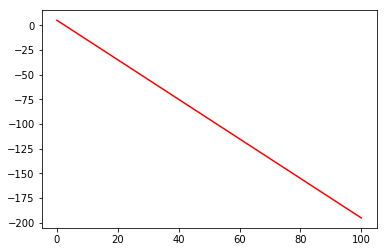

In [33]:
y_true = X @ beta.T

plt.plot(x1, y_true, 'r-')

Now add noise, and plot again.

In [34]:
#   add noise

sigma = 20
y_actual = y_true + np.random.normal(0, 1, n_data) * sigma
print(y_actual[0:4])

[ -4.0122347  -13.76334651   5.36237707  25.22258596]


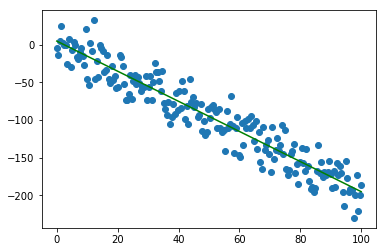

In [35]:
plt.plot(x1, y_actual, 'o')
plt.plot(x1, y_true, 'g-')

---
## Perform Linear Regression by OLS

The matrix equation for the estimated linear parameters is as below:

$${\hat {\beta }}=(X^{T}X)^{-1}X^{T}y.$$

The expressions in Wikipedia assume vectors are column vectors by default, but ```numpy``` has row vector by default.  Thus, the ```T``` operator  appears in the code in places where it doesn't in the Wikipedia formula (in order to turn row vectors into column vectors).

In [36]:
beta_estimated = np.linalg.inv(X.T @ X) @ X.T @ y_actual.T

In [37]:
beta_estimated

array([ 3.32852327, -1.98879143])

Calculate the sum of squared residual errors

$$RSS=y^{T}y-y^{T}X(X^{T}X)^{{-1}}X^{T}y.$$

In [38]:
RSS = (
    y_actual @ y_actual.T
    - y_actual
    @ X
    @ np.linalg.inv(X.T @ X)
    @ X.T
    @ y_actual.T
)

In [39]:
RSS

68517.60440778779

Calculated the Total Sum of Squares of the spread of the actual (noisy) values around their mean

$$TSS=(y-{\bar  y})^{T}(y-{\bar  y})=y^{T}y-2y^{T}{\bar  y}+{\bar  y}^{T}{\bar  y}.$$

In [40]:
y_mean = np.ones(n_data) * np.mean(y_actual)

TSS = (y_actual - y_mean).T @ (y_actual - y_mean)

TSS

734358.1094705117

In [41]:
y_pred = X @ beta_estimated.T

y_pred[0:4]

array([3.32852327, 2.32913059, 1.32973791, 0.33034523])

Calculate the Sum of Squares of the spread of the predictions around their mean.

$$ESS=({\hat  y}-{\bar  y})^{T}({\hat  y}-{\bar  y})={\hat  y}^{T}{\hat  y}-2{\hat  y}^{T}{\bar  y}+{\bar  y}^{T}{\bar  y}.$$

In [42]:
ESS = (y_pred - y_mean) @ (y_pred - y_mean).T

ESS

665840.505062724

Prove that TSS = ESS + RSS

In [43]:
TSS, ESS + RSS

(734358.1094705117, 734358.1094705118)

Get the amount of variation in the actual y values, that is explained by the linear model

In [44]:
1 - RSS / TSS

0.9066972863454991

Plot the result

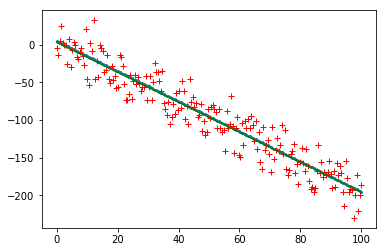

In [45]:
plt.plot(x1, y_true, 'o', markersize=2)
plt.plot(x1, y_actual, 'r+')
plt.plot(x1, y_pred, 'g-')

Calculate the standard error of the regression.  We divide by ```(n-2)```, because the Expectation of the sum of squares is ```(n-2)*sigma^2```.

In [46]:
#  standard error of regression

sr2 = (
    (1 / (n_data - 2))
    * (y_pred - y_actual)
    @ (y_pred - y_actual).T
)
sr = np.sqrt(sr2)
sr

18.602379071238097

In order to get the standard errors for our linear parameters, we use the matrix formula below:

$$Var(β^)=σ^2(X′X)^{-1}$$

In [47]:
# get variance / covariance matrix

var_beta = sr2 * np.linalg.inv(X.T @ X)
var_beta

array([[ 6.86932111e+00, -1.02781572e-01],
       [-1.02781572e-01,  2.05563143e-03]])

In [48]:
print(
    f'Std Error for b0 {np.sqrt(var_beta[0, 0])}, \nStd Error for b1 {np.sqrt(var_beta[1, 1])}'
)

Std Error for b0 2.620938975117275, 
Std Error for b1 0.04533907178466983


----
## Using OLS

Do it all again with ```ols``` call

In [49]:
x3 = [z[1] for z in X]
data = pd.DataFrame({'x': x3, 'y': y_actual})
res = ols('y ~ x', data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     1924.
Date:                Sun, 08 Mar 2020   Prob (F-statistic):          6.22e-104
Time:                        12:51:35   Log-Likelihood:                -867.44
No. Observations:                 200   AIC:                             1739.
Df Residuals:                     198   BIC:                             1745.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3285      2.621      1.270      0.206      -1.840       8.497
x             -1.9888      0.045    -43.865      0.000      -2.078      -1.899
==============================================================================
Omnibus:                        3.458   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                2.380
Skew:                           0.071   Prob(JB):                        0.304
Kurtosis:                       2.485   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that we get the same answers.  I strongly suspect that ```statsmodels``` has a fine-tuned algorithm, that would be more efficient than using ```numpy```.  After all, I use explicit matrix inversion, which is a minor numerical methods sin.

----
## Environment Definition

In [50]:
%watermark -h -iv

scipy       1.1.0
seaborn     0.9.0
pandas      1.0.0
matplotlib  3.0.2
statsmodels 0.9.0
numpy       1.15.4
host name: DESKTOP-SODFUN6


In [51]:
%watermark

2020-03-08T12:51:35+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
